Hypothesis Testing
==================

Copyright 2016 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
%matplotlib inline

import numpy
import scipy.stats

import matplotlib.pyplot as plt

import first

## Part One

Suppose you observe an apparent difference between two groups and you want to check whether it might be due to chance.

As an example, we'll look at differences between first babies and others.  The `first` module provides code to read data from the National Survey of Family Growth (NSFG).

In [2]:
live, firsts, others = first.MakeFrames()

We'll look at a couple of variables, including pregnancy length and birth weight.  The effect size we'll consider is the difference in the means.

Other examples might include a correlation between variables or a coefficient in a linear regression.  The number that quantifies the size of the effect is called the "test statistic".

In [3]:
def TestStatistic(data):
    group1, group2 = data
    test_stat = abs(group1.mean() - group2.mean())
    return test_stat

For the first example, I extract the pregnancy length for first babies and others.  The results are pandas Series objects.

In [4]:
group1 = firsts.prglngth
group2 = others.prglngth

The actual difference in the means is 0.078 weeks, which is only 13 hours.

In [5]:
actual = TestStatistic((group1, group2))
actual

0.07803726677754952

The null hypothesis is that there is no difference between the groups.  We can model that by forming a pooled sample that includes first babies and others.

In [6]:
n, m = len(group1), len(group2)
pool = numpy.hstack((group1, group2))

Then we can simulate the null hypothesis by shuffling the pool and dividing it into two groups, using the same sizes as the actual sample.

In [7]:
def RunModel():
    numpy.random.shuffle(pool)
    data = pool[:n], pool[n:]
    return data

The result of running the model is two NumPy arrays with the shuffled pregnancy lengths:

In [8]:
RunModel()

(array([39, 41, 32, ..., 36, 28, 43]), array([35, 40, 32, ..., 39, 35, 39]))

Then we compute the same test statistic using the simulated data:

In [9]:
TestStatistic(RunModel())

0.011930001380676458

If we run the model 1000 times and compute the test statistic, we can see how much the test statistic varies under the null hypothesis.

In [10]:
test_stats = numpy.array([TestStatistic(RunModel()) for i in range(1000)])
test_stats.shape

(1000,)

Here's the sampling distribution of the test statistic under the null hypothesis, with the actual difference in means indicated by a gray line.

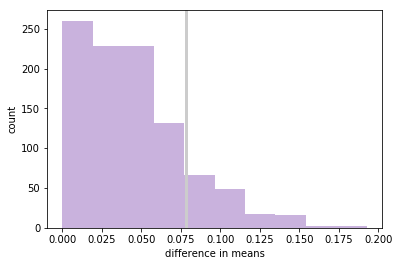

In [11]:
plt.axvline(actual, linewidth=3, color='0.8')
plt.hist(test_stats, color='C4', alpha=0.5)
plt.xlabel('difference in means')
plt.ylabel('count');

The p-value is the probability that the test statistic under the null hypothesis exceeds the actual value.

In [12]:
pvalue = sum(test_stats >= actual) / len(test_stats)
pvalue

0.15

In this case the result is about 15%, which means that even if there is no difference between the groups, it is plausible that we could see a sample difference as big as 0.078 weeks.

We conclude that the apparent effect might be due to chance, so we are not confident that it would appear in the general population, or in another sample from the same population.

STOP HERE
---------

Part Two
========

We can take the pieces from the previous section and organize them in a class that represents the structure of a hypothesis test.

In [ ]:
class HypothesisTest(object):
    """Represents a hypothesis test."""

    def __init__(self, data):
        """Initializes.

        data: data in whatever form is relevant
        """
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)
        self.test_stats = None

    def PValue(self, iters=1000):
        """Computes the distribution of the test statistic and p-value.

        iters: number of iterations

        returns: float p-value
        """
        self.test_stats = numpy.array([self.TestStatistic(self.RunModel()) 
                                       for _ in range(iters)])

        count = sum(self.test_stats >= self.actual)
        return count / iters

    def MaxTestStat(self):
        """Returns the largest test statistic seen during simulations.
        """
        return max(self.test_stats)

    def PlotHist(self, label=None):
        """Draws a Cdf with vertical lines at the observed test stat.
        """
        plt.hist(self.test_stats, color='C4', alpha=0.5)
        plt.axvline(self.actual, linewidth=3, color='0.8')
        plt.xlabel('test statistic')
        plt.ylabel('count')

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        raise UnimplementedMethodException()

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        pass

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        raise UnimplementedMethodException()


`HypothesisTest` is an abstract parent class that encodes the template.  Child classes fill in the missing methods.  For example, here's the test from the previous section.

In [ ]:
class DiffMeansPermute(HypothesisTest):
    """Tests a difference in means by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = numpy.hstack((group1, group2))

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        numpy.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

Now we can run the test by instantiating a DiffMeansPermute object:

In [ ]:
data = (firsts.prglngth, others.prglngth)
ht = DiffMeansPermute(data)
p_value = ht.PValue(iters=1000)
print('\nmeans permute pregnancy length')
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())

And we can plot the sampling distribution of the test statistic under the null hypothesis.

In [ ]:
ht.PlotHist()

### Difference in standard deviation

**Exercize 1**: Write a class named `DiffStdPermute` that extends `DiffMeansPermute` and overrides `TestStatistic` to compute the difference in standard deviations.  Is the difference in standard deviations statistically significant?

In [ ]:
# Solution goes here

Here's the code to test your solution to the previous exercise.

In [ ]:
data = (firsts.prglngth, others.prglngth)
ht = DiffStdPermute(data)
p_value = ht.PValue(iters=1000)
print('\nstd permute pregnancy length')
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())

### Difference in birth weights

Now let's run DiffMeansPermute again to see if there is a difference in birth weight between first babies and others.

In [ ]:
data = (firsts.totalwgt_lb.dropna(), others.totalwgt_lb.dropna())
ht = DiffMeansPermute(data)
p_value = ht.PValue(iters=1000)
print('\nmeans permute birthweight')
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())

In this case, after 1000 attempts, we never see a sample difference as big as the observed difference, so we conclude that the apparent effect is unlikely under the null hypothesis.  Under normal circumstances, we can also make the inference that the apparent effect is unlikely to be caused by random sampling.

One final note: in this case I would report that the p-value is less than 1/1000 or less than 0.001.  I would not report p=0, because  the apparent effect is not impossible under the null hypothesis; just unlikely.

### Part Three

In this section, we'll explore the dangers of p-hacking by running multiple tests until we find one that's statistically significant.

Suppose we want to compare IQs for two groups of people.  And suppose that, in fact, the two groups are statistically identical; that is, their IQs are drawn from a normal distribution with mean 100 and standard deviation 15.

I'll use `numpy.random.normal` to generate fake data I might get from running such an experiment:

In [ ]:
group1 = numpy.random.normal(100, 15, size=100)
group2 = numpy.random.normal(100, 15, size=100)

We expect the mean in both groups to be near 100, but just by random chance, it might be higher or lower.

In [ ]:
group1.mean(), group2.mean()

We can use DiffMeansPermute to compute the p-value for this fake data, which is the probability that we would see a difference between the groups as big as what we saw, just by chance.

In [ ]:
data = (group1, group2)
ht = DiffMeansPermute(data)
p_value = ht.PValue(iters=1000)
p_value

Now let's check the p-value.  If it's less than 0.05, the result is statistically significant, and we can publish it.  Otherwise, we can try again.

In [ ]:
if p_value < 0.05:
    print('Congratulations!  Publish it!')
else:
    print('Too bad!  Please try again.')

You can probably see where this is going.  If we play this game over and over (or if many researchers play it in parallel), the false positive rate can be as high as 100%.

To see this more clearly, let's simulate 100 researchers playing this game.  I'll take the code we have so far and wrap it in a function:

In [ ]:
def run_a_test(sample_size=100):
    """Generate random data and run a hypothesis test on it.

    sample_size: integer

    returns: p-value
    """
    group1 = numpy.random.normal(100, 15, size=sample_size)
    group2 = numpy.random.normal(100, 15, size=sample_size)
    data = (group1, group2)
    ht = DiffMeansPermute(data)
    p_value = ht.PValue(iters=200)
    return p_value

Now let's run that function 100 times and save the p-values.

In [ ]:
num_experiments = 100
p_values = numpy.array([run_a_test() for i in range(num_experiments)])
sum(p_values < 0.05)

On average, we expect to get a false positive about 5 times out of 100.  To see why, let's plot the histogram of the p-values we got.

In [ ]:
bins = numpy.linspace(0, 1, 21)
bins

In [ ]:
plt.hist(p_values, bins, color='C4', alpha=0.5)
plt.axvline(0.05, linewidth=3, color='0.8')
plt.xlabel('p-value')
plt.ylabel('count');

The distribution of p-values is uniform from 0 to 1.  So it falls below 5% about 5% of the time.

**Exercise:** If the threshold for statistical signficance is 5%, the probability of a false positive is 5%.  You might hope that things would get better with larger sample sizes, but they don't.  Run this experiment again with a larger sample size, and see for yourself.

### Part four

In the previous section, we computed the false positive rate, which is the probability of seeing a "statistically significant" result, even if there is no statistical difference between groups.

Now let's ask the complementary question: if there really is a difference between groups, what is the chance of seeing a "statistically significant" result?

The answer to this question is called the "power" of the test.  It depends on the sample size (unlike the false positive rate), and it also depends on how big the actual difference is.

We can estimate the power of a test by running simulations similar to the ones in the previous section.  Here's a version of `run_a_test` that takes the actual difference between groups as a parameter:

In [ ]:
def run_a_test2(actual_diff, sample_size=100):
    """Generate random data and run a hypothesis test on it.

    actual_diff: The actual difference between groups.
    sample_size: integer

    returns: p-value
    """
    group1 = numpy.random.normal(100, 15, 
                                 size=sample_size)
    group2 = numpy.random.normal(100 + actual_diff, 15, 
                                 size=sample_size)
    data = (group1, group2)
    ht = DiffMeansPermute(data)
    p_value = ht.PValue(iters=200)
    return p_value

Now let's run it 100 times with an actual difference of 5:

In [ ]:
p_values = numpy.array([run_a_test2(5) for i in range(100)])
sum(p_values < 0.05)

With sample size 100 and an actual difference of 5, the power of the test is approximately 65%.  That means if we ran this hypothetical experiment 100 times, we'd expect a statistically significant result about 65 times.

That's pretty good, but it also means we would NOT get a statistically significant result about 35 times, which is a lot.

Again, let's look at the distribution of p-values:

In [ ]:
plt.hist(p_values, bins, color='C4', alpha=0.5)
plt.axvline(0.05, linewidth=3, color='0.8')
plt.xlabel('p-value')
plt.ylabel('count');

Here's the point of this example: if you get a negative result (no statistical significance), that is not always strong evidence that there is no difference between the groups.  It is also possible that the power of the test was too low; that is, that it was unlikely to produce a positive result, even if there is a difference between the groups.

**Exercise:** Assuming that the actual difference between the groups is 5, what sample size is needed to get the power of the test up to 80%?  What if the actual difference is 2, what sample size do we need to get to 80%?